In [1]:
library(caret) ## Training the model
library(fields) ## Plotting
library(hydroGOF) ## Evaluation
library(pROC) ## Classification Evaluation
library(rpart) ## Tree-based model

Loading required package: ggplot2

Loading required package: lattice

Loading required package: spam

Spam version 2.11-0 (2024-10-03) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridisLite


Try help(fields) to get started.

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'hydroGOF'


The following object is masked from 'package:caret':

    R2


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var




In [ ]:
# Loading data
data <- read.csv("meteo.csv")
df.meteo <- data[, -1]; rm(data)
y <- df.meteo[, 1]  ## Predictando
x <- df.meteo[, -1]  ## Predictores

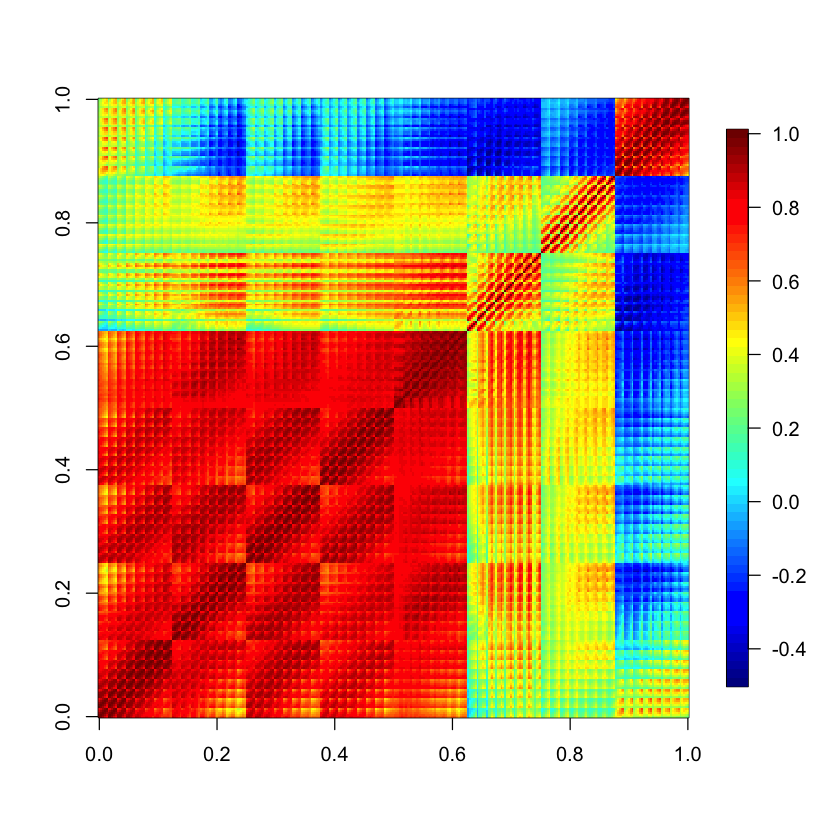

In [4]:
xCorr <- cor(x)
par(mfrow=c(1,1))
image.plot(xCorr)

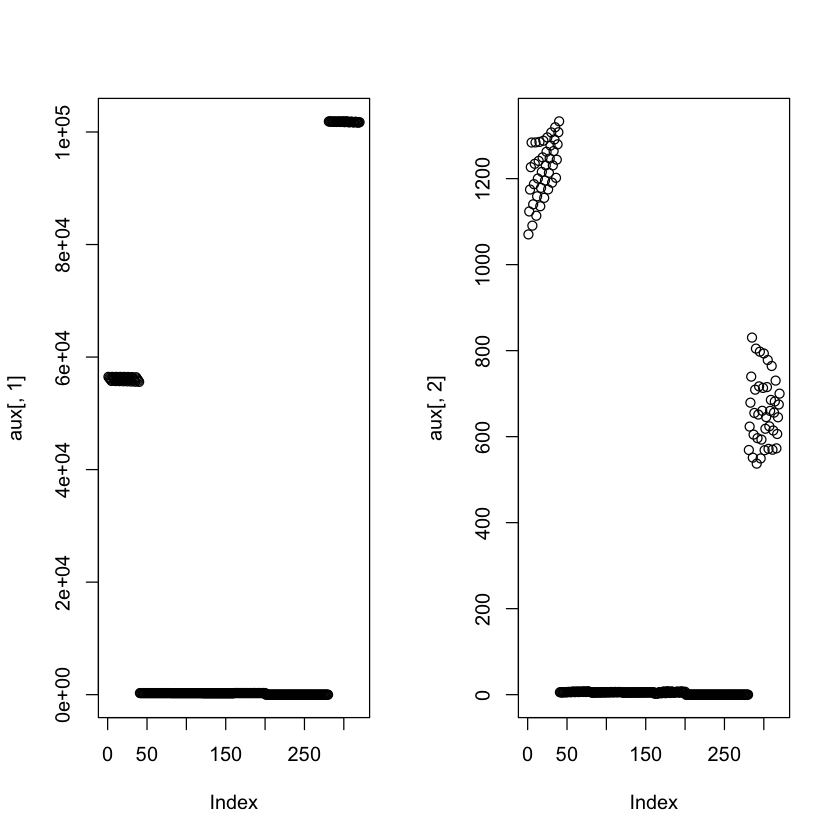

In [5]:
aux <- matrix(data = NA, nrow = ncol(x), 2)
aux[,1] <- apply(x, MARGIN = 2, FUN = mean, na.rm = TRUE)
aux[,2] <- apply(x, MARGIN = 2, FUN = sd, na.rm = TRUE)
par(mfrow=c(1,2))
plot(aux[,1])
plot(aux[,2])

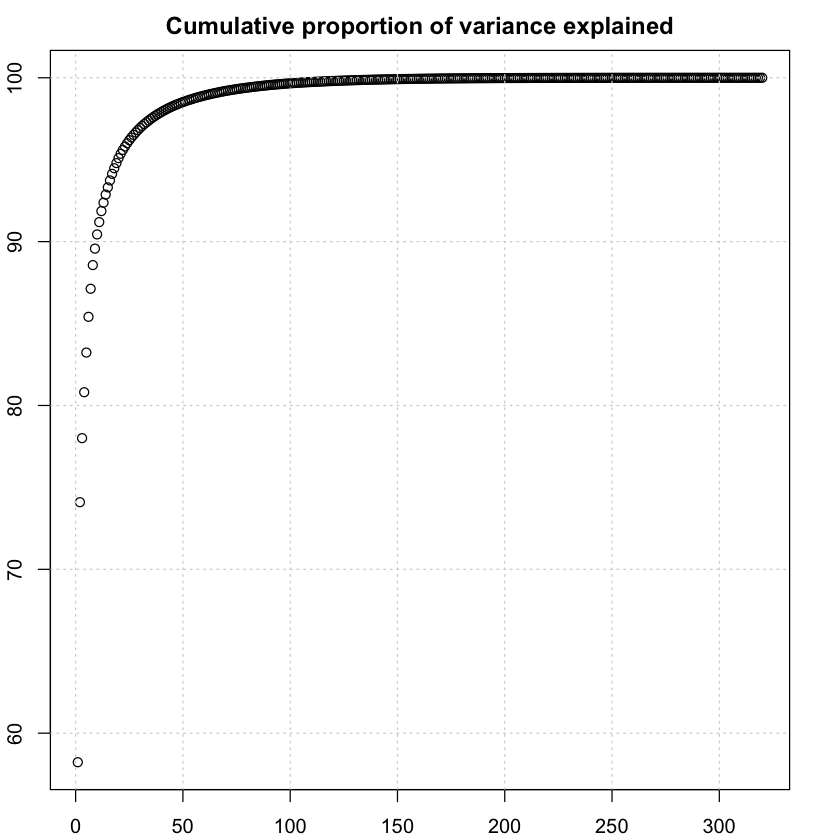

In [6]:
# PCA with R
PCA <- prcomp(x, center = TRUE, scale. = TRUE)
par(mfrow=c(1,1), mar=c(2.1,2.1,2.1,2.1))
plot(cumsum(PCA$sdev^2)/sum(PCA$sdev^2)*100,main="Cumulative proportion of variance explained")
grid()

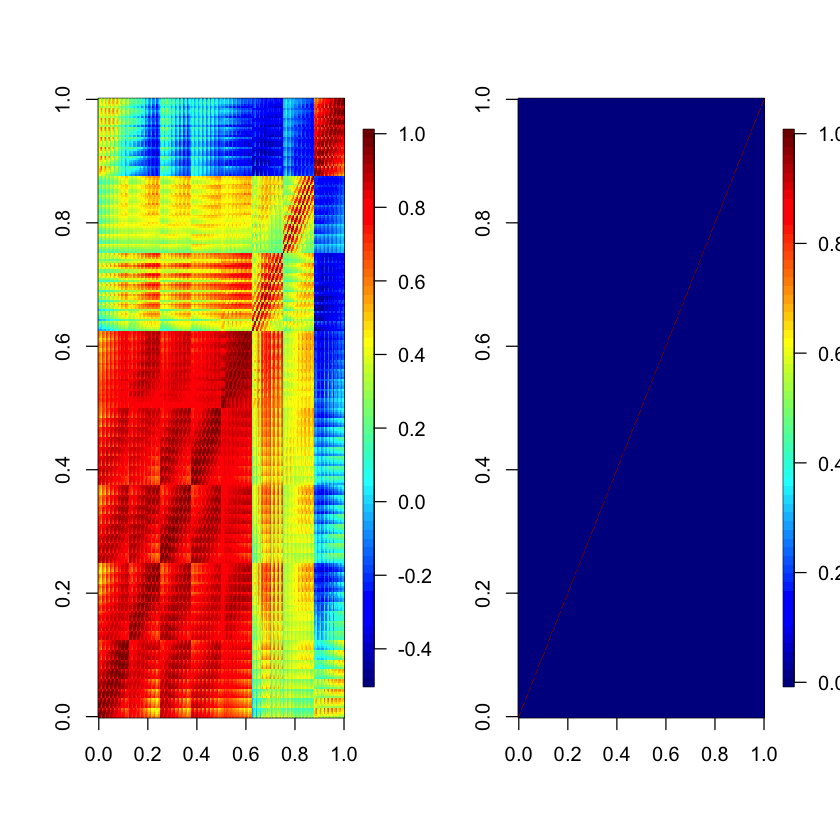

In [7]:
pcaCorr <- cor(PCA$x)
par(mfrow=c(1,2))
image.plot(xCorr)
image.plot(pcaCorr)

In [8]:
print(cumsum(PCA$sdev[1:50]^2)/sum(PCA$sdev^2)*100)

 [1] 58.22748 74.09688 78.00651 80.80834 83.23083 85.41027 87.12340 88.56891
 [9] 89.57316 90.44000 91.19128 91.86198 92.37748 92.86927 93.31144 93.73552
[17] 94.13585 94.47848 94.79342 95.09655 95.36363 95.59608 95.80465 96.00553
[25] 96.19090 96.35968 96.51440 96.66293 96.80242 96.93679 97.06009 97.17861
[33] 97.28529 97.38907 97.48892 97.58256 97.67308 97.75856 97.83745 97.91617
[41] 97.98793 98.05823 98.12651 98.18961 98.25215 98.30878 98.36299 98.41548
[49] 98.46684 98.51634


In [9]:
occu <- as.numeric(y > 1) ## Ocurrencia de precipitacion
occu[which(y <= 1)] <- 0
occu[which(y > 1)] <- 1
y[1:10]
occu[1:10]

[1] 10.9  0.6 13.0  0.0  0.0  1.2  1.1  0.0  0.0  0.7

[1] 1 0 1 0 0 1 1 0 0 0

## Linear- vs Trees-based Models
Una vez hemos definido las variables predictoras y objetivo, pasemos a identificar las familias de modelos a utilizar dentro del paquete CARET. ¿Contiene alguna implementación para los modelos lineales y basados en árboles? En caso afirmativo, ¿se consideran ambos casos: Clasificación y Predicción?
Definamos ahora el esquema de validación:

In [11]:
trainParams <- trainControl(method = "cv", number = 10, preProcOptions = list(pcaComp = 50))

In [12]:
indTrain <- createDataPartition(y,p=0.9,list=FALSE)
xTrain <- x[indTrain,]
yTrain <- y[indTrain]

xTest <- x[-indTrain,]
yTest <- y[-indTrain]
c(length(y),length(yTrain),length(yTest))

[1] 10958  9863  1095

In [13]:
# PCA with R
PCA <- prcomp(xTrain, center = TRUE, scale. = TRUE)
pcaTrain <- PCA$x[,1:50]
dim(pcaTrain)

[1] 9863   50

In [14]:
pcaTest <- predict(PCA, newdata = xTest)
dim(pcaTest)

[1] 1095  320

In [15]:
pcaTest <- pcaTest[,1:50]

In [16]:
## Regresion logistica
dfTrain <- data.frame(y = occu[indTrain], x=pcaTrain)
model <- glm(y~., data = dfTrain, family = binomial(link = "logit"))
out <- model$fitted.values
outbin <- as.double(out > 0.5)
table(occu[indTrain], outbin)
100*sum(diag(table(occu[indTrain], outbin))) / length(outbin)

   outbin
       0    1
  0 7551  375
  1  700 1237

[1] 89.10068

In [ ]:
dfTest <- data.frame(y = occu[-indTrain], x=pcaTest)
out1 <- predict(model, newdata = dfTest, type = "response")
outbin1 <- as.double(out1 > 0.5)
table(occu[-indTrain], outbin1)
100*sum(diag(table(occu[-indTrain], outbin1))) / length(outbin1)

   outbin1
      0   1
  0 825  47
  1  78 145

[1] 88.58447

In [18]:
trainParams <- trainControl(method = "cv", number = 10, preProcOptions = list(pcaComp = 50, thres = 0.95))

In [19]:
dfTrain <- data.frame(y = as.factor(occu), x=x)
modelFit <- train(y ~ ., data=dfTrain, method="glm", trControl=trainParams, preProcess = "pca")
str(modelFit)

List of 24
 $ method      : chr "glm"
 $ modelInfo   :List of 15
  ..$ label     : chr "Generalized Linear Model"
  ..$ library   : NULL
  ..$ loop      : NULL
  ..$ type      : chr [1:2] "Regression" "Classification"
  ..$ parameters:'data.frame':	1 obs. of  3 variables:
  .. ..$ parameter: chr "parameter"
  .. ..$ class    : chr "character"
  .. ..$ label    : chr "parameter"
  ..$ grid      :function (x, y, len = NULL, search = "grid")  
  ..$ fit       :function (x, y, wts, param, lev, last, classProbs, ...)  
  ..$ predict   :function (modelFit, newdata, submodels = NULL)  
  ..$ prob      :function (modelFit, newdata, submodels = NULL)  
  ..$ varImp    :function (object, ...)  
  ..$ predictors:function (x, ...)  
  ..$ levels    :function (x)  
  ..$ trim      :function (x)  
  ..$ tags      : chr [1:4] "Generalized Linear Model" "Linear Classifier" "Two Class Only" "Accepts Case Weights"
  ..$ sort      :function (x)  
 $ modelType   : chr "Classification"
 $ results     :'dat

In [20]:
yPred <- predict(modelFit,newdata = dfTrain)
confusionMatrix(as.factor(occu),yPred)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8377  421
         1  782 1378
                                         
               Accuracy : 0.8902         
                 95% CI : (0.8842, 0.896)
    No Information Rate : 0.8358         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6298         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9146         
            Specificity : 0.7660         
         Pos Pred Value : 0.9521         
         Neg Pred Value : 0.6380         
             Prevalence : 0.8358         
         Detection Rate : 0.7645         
   Detection Prevalence : 0.8029         
      Balanced Accuracy : 0.8403         
                                         
       'Positive' Class : 0              
                                         

In [21]:
yPred <- predict(modelFit,newdata = dfTrain, type="prob")
roc_obj <- roc(as.factor(occu), yPred[["1"]])
auc(roc_obj)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9325

In [22]:
trainParams <- trainControl(method = "cv", number = 10, preProcOptions = list(pcaComp = 50, thres = 0.95))
dfTrain <- data.frame(y = as.factor(occu), x=x)
treeGrid <- expand.grid(cp = 10^c(-1:-5))
treeFit <- train(y ~ ., data=dfTrain, method="rpart", trControl=trainParams, tuneGrid = treeGrid, preProcess = "pca")
str(treeFit)

List of 24
 $ method      : chr "rpart"
 $ modelInfo   :List of 15
  ..$ label     : chr "CART"
  ..$ library   : chr "rpart"
  ..$ type      : chr [1:2] "Regression" "Classification"
  ..$ parameters:'data.frame':	1 obs. of  3 variables:
  .. ..$ parameter: chr "cp"
  .. ..$ class    : chr "numeric"
  .. ..$ label    : chr "Complexity Parameter"
  ..$ grid      :function (x, y, len = NULL, search = "grid")  
  ..$ loop      :function (grid)  
  ..$ fit       :function (x, y, wts, param, lev, last, classProbs, ...)  
  ..$ predict   :function (modelFit, newdata, submodels = NULL)  
  ..$ prob      :function (modelFit, newdata, submodels = NULL)  
  ..$ predictors:function (x, surrogate = TRUE, ...)  
  ..$ varImp    :function (object, surrogates = FALSE, competes = TRUE, ...)  
  ..$ levels    :function (x)  
  ..$ trim      :function (x)  
  ..$ tags      : chr [1:4] "Tree-Based Model" "Implicit Feature Selection" "Handle Missing Predictor Data" "Accepts Case Weights"
  ..$ sort      

Evaluamos ahora el modelo respecto a toda la muestra:

In [23]:
yTree <- predict(treeFit,newdata = dfTrain)
confusionMatrix(as.factor(occu),yTree)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8433  365
         1 1216  944
                                         
               Accuracy : 0.8557         
                 95% CI : (0.849, 0.8623)
    No Information Rate : 0.8805         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.4646         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.8740         
            Specificity : 0.7212         
         Pos Pred Value : 0.9585         
         Neg Pred Value : 0.4370         
             Prevalence : 0.8805         
         Detection Rate : 0.7696         
   Detection Prevalence : 0.8029         
      Balanced Accuracy : 0.7976         
                                         
       'Positive' Class : 0              
                                         

Incluyendo el AUC para comparar adecuadamente ambos modelos:

In [24]:
yTree <- predict(treeFit,newdata = dfTrain, type="prob")
roc_obj <- roc(as.factor(occu), yTree[["1"]])
auc(roc_obj)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8009

### Muestras Desbalanceadas:
A la vista de los resultados anteriores, ¿se observa algún problema asociado a la frecuencia de los casos positivos y negativos? Este problema se conoce como desbalanceo de la muestra y hay diferentes aproximaciones para resolverlo, algunas de las cuales están recogidas en CARET. Ver la Sección 11.

## Predicción:
Una vez resuelta la parte binaria de la precipitación, pasamos a predecir la cantidad para aquellos días en los cuales se haya dado precipitación. En el caso de los modelos lineales esta división es necesaria por las hipótesis impuestas sobre las funciones de enlace, el comportamiento de los residuos, etc... ¿Ocurre lo mismo para los modelos basados en árboles?
Consideremos la muestra asociada a los días de precipitación:

In [25]:
indRain <- which(y > 1)
dfTrain <- data.frame(y = y[indRain], x=x[indRain,])

Notar que la variable `indRain` contiene las posiciones de los días con precipitación y nos permitirá asignar los valores predichos a las posiciones correspondientes del vector de predicciones sobre todo el periodo.

### Modelos Lineales Generalizados:
Como vimos en el problema de clasificación, realmente no tenemos ningún parámetro extra que ajustar en el GLM, de modo que podemos replicar el ajuste, esta vez considerando únicamente los datos de precipitación:

In [26]:
trainParams <- trainControl(method = "cv", number = 10, preProcOptions = list(pcaComp = 50, thres = 0.95))
modelFit <- train(y ~ ., data=dfTrain, method="glm", trControl=trainParams, preProcess = "pca")
str(modelFit)

List of 24
 $ method      : chr "glm"
 $ modelInfo   :List of 15
  ..$ label     : chr "Generalized Linear Model"
  ..$ library   : NULL
  ..$ loop      : NULL
  ..$ type      : chr [1:2] "Regression" "Classification"
  ..$ parameters:'data.frame':	1 obs. of  3 variables:
  .. ..$ parameter: chr "parameter"
  .. ..$ class    : chr "character"
  .. ..$ label    : chr "parameter"
  ..$ grid      :function (x, y, len = NULL, search = "grid")  
  ..$ fit       :function (x, y, wts, param, lev, last, classProbs, ...)  
  ..$ predict   :function (modelFit, newdata, submodels = NULL)  
  ..$ prob      :function (modelFit, newdata, submodels = NULL)  
  ..$ varImp    :function (object, ...)  
  ..$ predictors:function (x, ...)  
  ..$ levels    :function (x)  
  ..$ trim      :function (x)  
  ..$ tags      : chr [1:4] "Generalized Linear Model" "Linear Classifier" "Two Class Only" "Accepts Case Weights"
  ..$ sort      :function (x)  
 $ modelType   : chr "Regression"
 $ results     :'data.fr

Obtenemos ahora las predicciones sobre los días de precipitación:

In [27]:
yPred <- predict(modelFit,newdata = dfTrain)

Validemos ahora la predicción obtenida con diferentes parámetros:
- Day-to-day correspondence: ¿qué medidas conoces que evalúen la correspondencia entre ambas series?
- Accuracy: ¿qué medidas de precisión conoces?
- Distributional similarity: ¿qué medidas de comparación de la distribución estadística conoces?

Revisar los parámetros de validación incluidos en el paquete hydroGOF y ver si alguno se corresponde con las características antes expuestas.

In [28]:
## Por ejemplo, RMSE:
RMSEglm=rmse(yPred,dfTrain$y)
print(RMSEglm)

[1] 9.815054


El Kolmogorov-Smirnov Test (? ks.test) ¿con qué característica de las anteriores se corresponde?

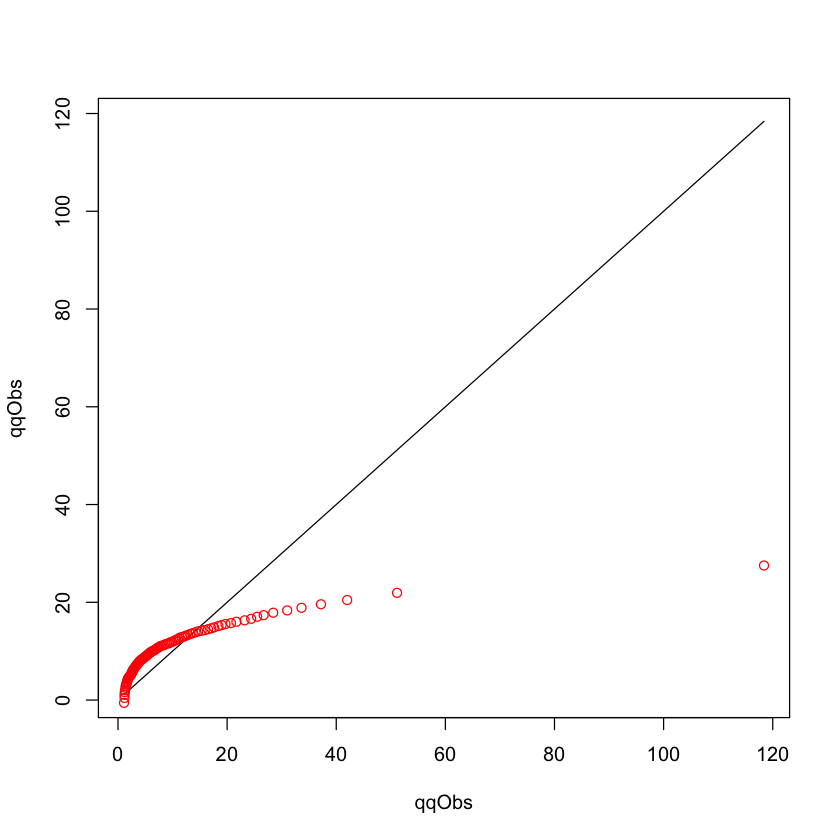

In [29]:
qqObs <- quantile(dfTrain$y, probs = seq(0, 1, 0.01), na.rm = TRUE)
qqPrd <- quantile(yPred, probs = seq(0, 1, 0.01), na.rm = TRUE)
par(mfrow=c(1,1))
plot(qqObs,qqObs, type = "l")
points(qqObs,qqPrd, col = "red")

A la vista del gráfico anterior, ¿cómo se está comportando nuestro modelo?
### Árboles de Regresión:
En base a lo visto en los puntos anterior, extiende el análisis a los métodos basados en árboles y comparar con los resultados obtenidos para el modelo lineal.